## **실습 진행 부분**

## **실습을 진행하셔야 과제 진행을 할 수 있습니다.**


## kaggle API 연동


In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"oreoinmilk","key":"dd5652736bffa49d1c39f69ac7382aa2"}'}

In [3]:
!ls -1ha kaggle.json

kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기
!kaggle competitions list

ref                                                                               deadline             category            reward  teamCount  userHasEntered  
--------------------------------------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
https://www.kaggle.com/competitions/llm-detect-ai-generated-text                  2024-01-22 23:59:00  Featured          $110,000       1585           False  
https://www.kaggle.com/competitions/open-problems-single-cell-perturbations       2023-11-30 23:59:00  Featured          $100,000       1095           False  
https://www.kaggle.com/competitions/stanford-ribonanza-rna-folding                2023-12-07 23:59:00  Research          $100,000        653           False  
https://www.kaggle.com/competitions/optiver-trading-at-the-close                  2023-12-20 23:59:00  Featured          $100,000       3365           False  
https://www.kaggle.com/competitions/nfl-big-da

In [5]:
!kaggle datasets download -d bulentsiyah/semantic-drone-dataset

100% 3.88G/3.89G [00:38<00:00, 164MB/s]
100% 3.89G/3.89G [00:38<00:00, 109MB/s]


In [6]:
!unzip semantic-drone-dataset.zip

Archive:  semantic-drone-dataset.zip
  inflating: RGB_color_image_masks/RGB_color_image_masks/000.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/001.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/002.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/003.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/004.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/005.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/006.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/008.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/011.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/013.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/014.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/015.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/016.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/018.png  
  inflating: RGB_color_im

## Import Libraries

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.2 MB/s eta 0:00:00


In [8]:
device

device(type='cuda')

## Preprocessing


In [9]:
IMAGE_PATH = 'dataset/semantic_drone_dataset/original_images/'
MASK_PATH = 'dataset/semantic_drone_dataset/label_images_semantic/'

In [10]:
n_classes = 23

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


In [11]:
#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  306
Val Size     :  54
Test Size    :  40


Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


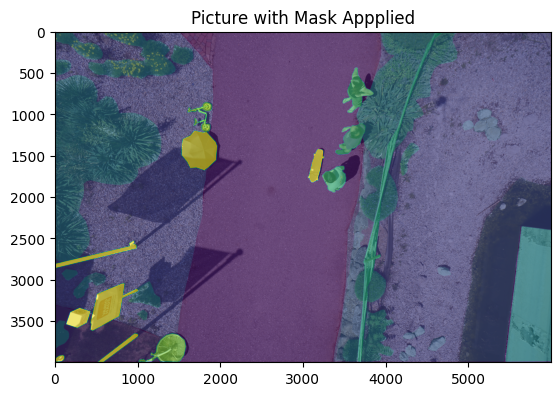

In [12]:
img = Image.open(IMAGE_PATH + df['id'][100] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

## Custom DataSet Loader


In [13]:
class DroneDataset(Dataset):

    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()

        if self.patches:
            img, mask = self.tiles(img, mask)

        return img, mask

    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768)
        img_patches = img_patches.permute(1,0,2,3)

        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)

        return img_patches, mask_patches

In [14]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(450, 600, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip()])
t_val = A.Compose([A.Resize(450, 600, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip()])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 3

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

Feature batch shape: torch.Size([3, 3, 450, 600])
Labels batch shape: torch.Size([3, 450, 600])


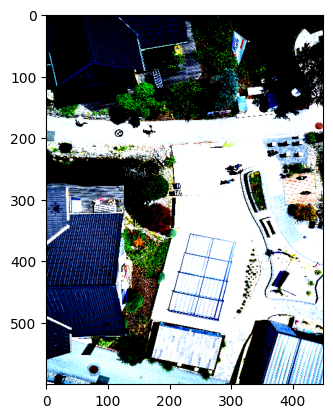

Label: tensor([[ 0,  0,  0,  ...,  0,  1,  1],
        [ 0,  9,  9,  ...,  1,  1,  1],
        [ 0,  9,  9,  ...,  1,  1,  1],
        ...,
        [ 1, 22, 22,  ...,  9,  9,  9],
        [ 1, 22, 22,  ...,  9,  9,  9],
        [22, 22, 22,  ...,  9,  9,  9]])


In [15]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
import matplotlib.pyplot as plt
plt.imshow(img.permute(2,1,0))
plt.show()
print(f"Label: {label}")

## UNet Architecture

In [16]:
import torch.nn as nn
from torch.nn import functional as F


class Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.blocks = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.blocks(x)


class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = Block(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.pool(x)
        x = self.encoder(x)
        return x


class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.decoder = Block(in_channels, out_channels)

    def forward(self, x, encoder_features):
        x = self.up(x)
        diffY = encoder_features.size()[2] - x.size()[2]
        diffX = encoder_features.size()[3] - x.size()[3]
        x = F.pad(x, [diffX // 2, diffX - diffX // 2,
                      diffY // 2, diffY - diffY // 2])
        x = torch.cat([encoder_features, x], dim=1)
        x = self.decoder(x)
        return x


class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = Block(3, 64)
        self.encoder1 = Encoder(64, 128)
        self.encoder2 = Encoder(128, 256)
        self.encoder3 = Encoder(256, 512)
        self.encoder4 = Encoder(512, 1024)

        self.decoder1 = Decoder(1024, 512)
        self.decoder2 = Decoder(512, 256)
        self.decoder3 = Decoder(256, 128)
        self.decoder4 = Decoder(128, 64)
        self.output = nn.Conv2d(64, 23, kernel_size=1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x1 = self.input(x)
        x2 = self.encoder1(x1)
        x3 = self.encoder2(x2)
        x4 = self.encoder3(x3)
        x5 = self.encoder4(x4)

        x = self.decoder1(x5, x4)
        x = self.decoder2(x, x3)
        x = self.decoder3(x, x2)
        x = self.decoder4(x, x1)
        x = self.output(x)
        x = self.softmax(x)
        return x

## Unet Architecture Not Skip Connection


In [17]:
import torch.nn as nn
from torch.nn import functional as F


class Block2(nn.Module):
    # ToDo: Skip connection을 사용하지 않는 Unet을 완성하기
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.blocks = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.blocks(x)

class Encoder2(nn.Module):
    # ToDo: Skip connection을 사용하지 않는 Unet을 완성하기
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = Block2(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.pool(x)
        x = self.encoder(x)
        return x

class Decoder2(nn.Module):
    # ToDo: Skip connection을 사용하지 않는 Unet을 완성하기
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, padding = 1, stride=2)
        self.decoder = Block2(in_channels, out_channels)

    def forward(self, x, encoder_features):
        x = self.up(x)
        diffY = encoder_features.size()[2] - x.size()[2]
        diffX = encoder_features.size()[3] - x.size()[3]
        x = F.pad(x, [diffX // 2, diffX - diffX // 2,
                      diffY // 2, diffY - diffY // 2])
        x = torch.cat([x, x], dim=1)
        # x = torch.cat([encoder_features, x], dim=1)
        x = self.decoder(x)
        return x


class UNetNoSkip(nn.Module):
    def __init__(self):
        super().__init__()
        # ToDo: Skip connection을 사용하지 않는 Unet을 완성하기
        super().__init__()

        self.input = Block2(3, 64)
        self.encoder1 = Encoder2(64, 128)
        self.encoder2 = Encoder2(128, 256)
        self.encoder3 = Encoder2(256, 512)
        self.encoder4 = Encoder2(512, 1024)


        self.decoder1 = Decoder2(1024, 512)
        self.decoder2 = Decoder2(512, 256)
        self.decoder3 = Decoder2(256, 128)
        self.decoder4 = Decoder2(128, 64)
        self.output = nn.Conv2d(64, 23, kernel_size=1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # ToDo: Skip connection을 사용하지 않는 Unet을 완성하기
        x1 = self.input(x)
        # print(f"input : {x.size()} -> {x1.size()}")
        x2 = self.encoder1(x1)
        # print(f"64 to 128 : {x1.size()} -> {x2.size()}")
        x3 = self.encoder2(x2)
        # print(f"128 to 256 : {x2.size()} -> {x3.size()}")
        x4 = self.encoder3(x3)
        # print(f"256 to 512 : {x3.size()} -> {x4.size()}")
        x5 = self.encoder4(x4)
        # print(f"512 to 1024 : {x4.size()} -> {x5.size()}")

        # print("Encoder End, Decoder Start")

        x = self.decoder1(x5, x4)
        # print(f"1024 to 512 : {x5.size()} -> {x.size()}")
        x = self.decoder2(x, x3)
        # print(f"512 to 256 : {x.size()}")
        x = self.decoder3(x, x2)
        # print(f"256 to 128 : {x.size()}")
        x = self.decoder4(x, x1)
        # print(f"128 to 64 : {x.size()}")
        x = self.output(x)
        x = self.softmax(x)
        return x

# Declare Eval Metric

In [18]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [19]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

## Unet Training (Skip Conneection O)

In [20]:
model = UNetNoSkip()

In [21]:
model

UNetNoSkip(
  (input): Block2(
    (blocks): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (encoder1): Encoder2(
    (encoder): Block2(
      (blocks): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (pool): MaxPool2d(kernel_size=2,

In [22]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image);
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight
            optimizer.zero_grad() #reset gradient

            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))


            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break

            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))

    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [23]:
max_lr = 5e-4
epoch = 5
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 2.906 
Epoch:1/5.. Train Loss: 3.025.. Val Loss: 2.906.. Train mIoU:0.040.. Val mIoU: 0.060.. Train Acc:0.251.. Val Acc:0.474.. Time: 5.85m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 2.906 >> 2.773 
Epoch:2/5.. Train Loss: 2.827.. Val Loss: 2.773.. Train mIoU:0.062.. Val mIoU: 0.063.. Train Acc:0.481.. Val Acc:0.492.. Time: 5.63m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 2.773 >> 2.704 
Epoch:3/5.. Train Loss: 2.702.. Val Loss: 2.704.. Train mIoU:0.069.. Val mIoU: 0.073.. Train Acc:0.529.. Val Acc:0.529.. Time: 5.60m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 2.704 >> 2.639 
saving model...
Epoch:4/5.. Train Loss: 2.677.. Val Loss: 2.639.. Train mIoU:0.072.. Val mIoU: 0.083.. Train Acc:0.542.. Val Acc:0.577.. Time: 5.55m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:5/5.. Train Loss: 2.670.. Val Loss: 2.665.. Train mIoU:0.073.. Val mIoU: 0.077.. Train Acc:0.547.. Val Acc:0.549.. Time: 5.56m
Total time: 28.18 m


In [24]:
torch.save(model, 'Unet-NoSkip-True.pt')

In [25]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

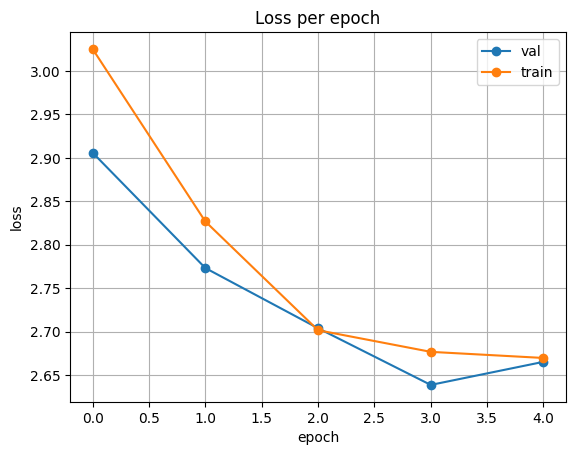

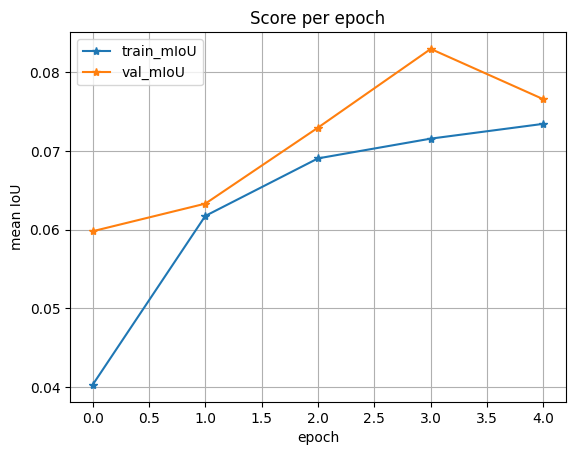

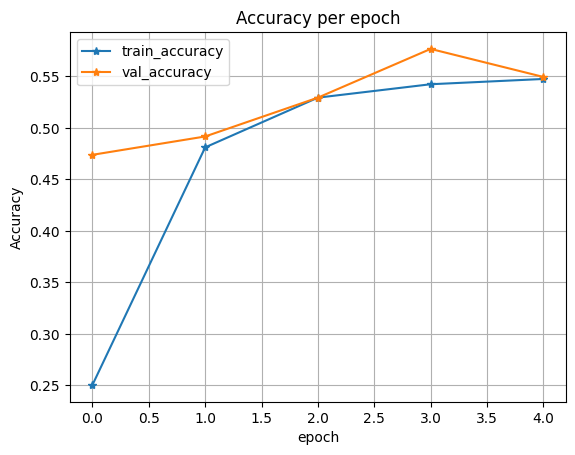

In [26]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [27]:
class DroneTestDataset(Dataset):

    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        mask = torch.from_numpy(mask).long()

        return img, mask


t_test = A.Resize(450, 600, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [28]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [29]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [30]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [31]:
mob_miou = miou_score(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

In [32]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [33]:
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

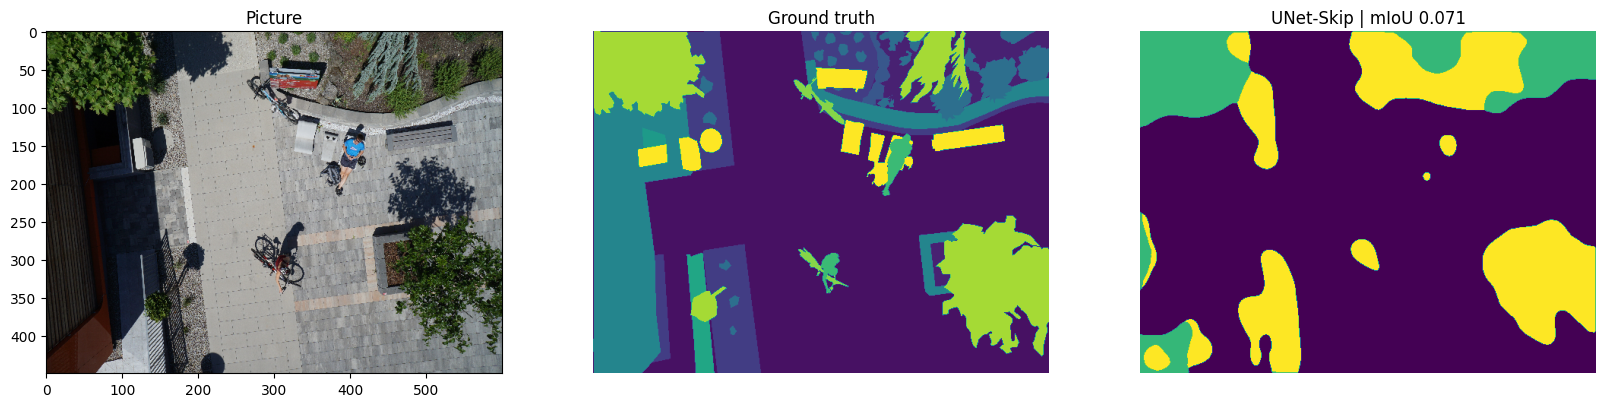

In [34]:
image2, mask2 = test_set[4]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-Skip | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()


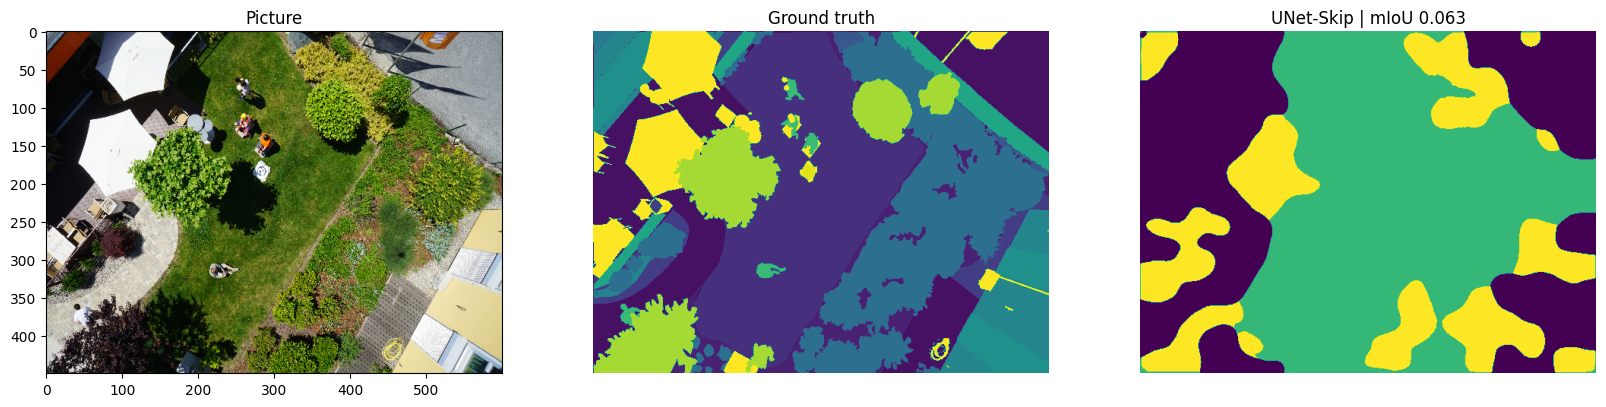

In [35]:
image3, mask3 = test_set[6]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-Skip | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [36]:
np.array(mob_acc).mean()

0.5375488888888889